<a href="https://colab.research.google.com/github/bhuvnk/skunworks/blob/main/Phase1/1.%20Protonet/ProtoNet_Omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prototypical Netwoks: Omniglot dataset


`Credit:` [https://github.com/jakesnell/prototypical-networks](https://github.com/jakesnell/prototypical-networks)



##Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


##Import data

The Omniglot dataset is taken on [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [3]:
#Download and Extract
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

--2020-11-08 08:33:13--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2020-11-08 08:33:13--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.1s    

2020-11-08 08:33:13 (58.8 MB/s) - ‘images_evaluation.zip’ saved [646288

## Reading the Omniglot

1623 Handwritten Character || 50 Alphabets || By 20 People

1623 * 4 = 6492; if we consider orthogonal flips

* 30 Alphabets | Background Set | Training
* 20 Alphabets | Evaluation Set | Testing


In [4]:
from tqdm.notebook import tqdm
def load_characters(root, alphabet):
    '''
    iterate through one alphabet folder and return image(0,90,180,270 rotations),label
    Input: alphabet folder
    Return: X,y  
    '''
    X = []
    y = []
    
    alphabet_path = os.path.join(root, alphabet)
    characters = os.listdir(alphabet_path)
    
    for char in characters:
        char_path = os.path.join(alphabet_path, char)
        images = os.listdir(char_path)
        
        for img in images:
            image = cv2.imread(os.path.join(char_path, img))
            image = cv2.resize(image, (28, 28)) / 255
            #rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            X.extend((image, rotated_90, rotated_180, rotated_270))
            y.extend((
                alphabet + '_' + char + '_0',
                alphabet + '_' + char + '_90',
                alphabet + '_' + char + '_180',
                alphabet + '_' + char + '_270'
            ))
            
            # X.append(image)
            # y.append(f'{alphabet}_{char}')
    
    return X, y


def read_images(root):
    '''
    iterate through root folder and read all in
    Loads the full omniglot dataset from a root directory
    '''
    X_data = []
    y_data = []
    
    print('Loading Data')
    
    alphabets = os.listdir(root)
    for alphabet in tqdm(alphabets):
        X, y = load_characters(root, alphabet)
        X_data.extend(X)
        y_data.extend(y)
    
    return np.array(X_data), np.array(y_data)

In [5]:
# Read the training data
trainx, trainy = read_images('images_background')

Loading Data


In [6]:
# Read in evaluation/testing/validation data
testx, testy = read_images('images_evaluation')

Loading Data


In [7]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120, 28, 28, 3), (77120,), (52720, 28, 28, 3), (52720,))

* Training set | 77,120 images | 964 * 4 = 3,856 characters * 20 people | images_background
* Testing set | 52,720 images | 659 * 4 = 2,636 characters * 20 People | images_evaluation

##Create samples

In [8]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
    Returns a Task with support and query set combined
    task sample : (n_way, n_support+n_query, (image dim))
    plus these info: n_way, n_support, n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




In [9]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

* 8: classes
* [:, :5] = support images
* [:, 5:] = query images | 40 samples

8way, 5 shot learning

In [10]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


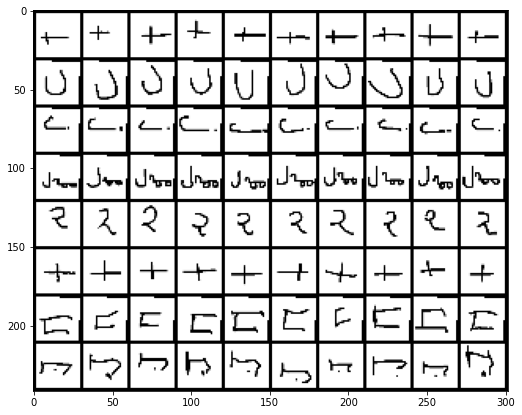

In [11]:
display_sample(sample_example['images'])

##Build model

Paper: [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

Embedding : 
* Input: (28x28x3) image 
* Returns : 64 lenght vector.

load_protonet_conv(Image2vector) function
* 4 modules
* each 64-filter 3 x 3 convolution -> BN -> ReLU -> 2 x 2 MP 

finally flattened to 64

In [12]:
## Encoder
def conv_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2)
      )
  
class Image2vector(nn.Module):
    
    def __init__(self, **kwargs):
        super(Image2vector, self).__init__()
        
        self.conv1 = conv_block(3, 64) 
        self.conv2 = conv_block(64, 64) 
        self.conv3 = conv_block(64, 64) 
        self.conv4 = conv_block(64, 64) 
                
    def forward(self, x): # 3 *  28x28
        
        x = self.conv1(x) # 64* 14x14 | (28+1(padding)-2(3x3conv)) / 2(mp)
        x = self.conv2(x) # 64 * 7x7
        x = self.conv3(x) # 64 * 3x3
        x = self.conv4(x) # 64 * 1x1
        
        out = x.view(x.size(0), -1) # 64 embedding
        
        return out

In [13]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    encoder : CNN encoding the images in sample
    from sample data: 
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
    _, y_hat = log_p_y.max(2)

      
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [14]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

##Train

In [15]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [16]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [17]:
%%time

# model = load_protonet_conv(
#     x_dim=(3,28,28),
#     hid_dim=64,
#     z_dim=64,
#     )

model = ProtoNet(Image2vector())
optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 5
n_support = 1
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000 # episodes

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Epoch 1 -- Loss: 0.1971 Acc: 0.9371



Epoch 2 -- Loss: 0.0803 Acc: 0.9728



Epoch 3 -- Loss: 0.0555 Acc: 0.9812



Epoch 4 -- Loss: 0.0433 Acc: 0.9853



Epoch 5 -- Loss: 0.0362 Acc: 0.9878
CPU times: user 8min 35s, sys: 6.29 s, total: 8min 41s
Wall time: 8min 47s


##Test

In [18]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [19]:
n_way = 5
n_support = 1
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app



Test results -- Loss: 0.0629 Acc: 0.9788


##Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


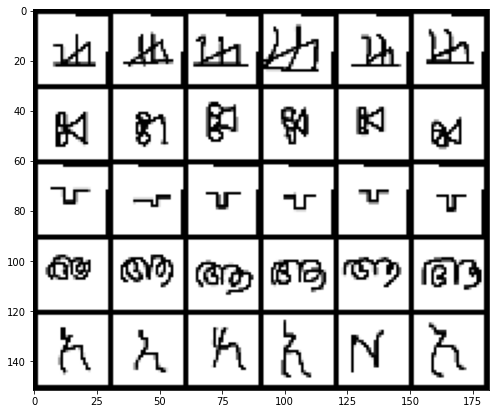

In [20]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [21]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [22]:
my_output

{'acc': 1.0, 'loss': 0.027699055150151253, 'y_hat': tensor([[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}